In [1]:
using Knet
using CUDA
using NPZ
using Statistics
using Images
using Plots
using ProgressMeter

## Model and Loss

In [2]:
struct Activ; f; o; end
Activ(f, o...) = Activ(f, o)
(a::Activ)(x) = a.f.(x, a.o...)

struct Conv; w; b; end
Conv(w1::Int,w2::Int,cx::Int,cy::Int) = Conv(param(w1,w2,cx,cy), param0(1,1,cy,1))
(c::Conv)(x) = conv4(c.w, x) .+ c.b

struct Chain; l; end
Chain(l...) = Chain(l)
(c::Chain)(x) = (for l in c.l; x = l(x); end; x)

In [3]:
struct PixTransform; spatial; color; head; θ end

PixTransform(θ) =
    PixTransform(
        Chain([Conv(1,1,2,32), Activ(θ["α"]), Conv(1,1,32,2048)]),
        Chain([Conv(1,1,θ["channels"]-2,32), Activ(θ["α"]), Conv(1,1,32,2048)]),
        Chain([Activ(θ["α"]), Conv(1,1,2048,32), Activ(θ["α"]), Conv(1,1,32,1)]),
        θ)

function (m::PixTransform)(x)
    ŷ = m.head(m.spatial(x[:,:,m.θ["channels"]-1:end,:]) .+ m.color(x[:,:,1:m.θ["channels"]-2,:]))
end

function (m::PixTransform)(x,y)
    ŷ = m(x)
    μ_y, μ_ŷ = reshape.((y, mean(ŷ, dims=(1,2))), length(y))
    l = (m.θ["ℓ"](μ_y, μ_ŷ)
        + m.θ["reg"](m.spatial.l[1].w, m.θ["λ"][1]) 
        + m.θ["reg"](m.spatial.l[3].w, m.θ["λ"][1])
        + m.θ["reg"](m.color.l[1].w, m.θ["λ"][2]) 
        + m.θ["reg"](m.color.l[1].w, m.θ["λ"][2])
        + m.θ["reg"](m.head.l[2].w, m.θ["λ"][3]) 
        + m.θ["reg"](m.head.l[4].w, m.θ["λ"][3])
        )
end
(m::PixTransform)(d::Knet.Data) = mean(m(x,y) for (x,y) in d)

## Training and Prediction

In [4]:
function predict(guide, source)
    source = squeeze(source)
    H_, W_, C = size(guide)
    H, W = size(source)
    D = H_ ÷ H
    M = H
    N = H_

    @assert (H_ == W_)
    @assert (H == W)
    @assert (H_ % H == 0)

    guide = (guide .- mean(guide, dims=(1, 2))) ./ std(guide, dims=(1, 2))
    μ_s, σ_s = mean(source), std(source)
    source = (source .- μ_s) ./ σ_s

    grid = reshape(repeat(range(-0.5,0.5,length=H_),1,H_), (H_,H_,1))
    guide = cat(guide, grid, permutedims(grid, (2,1,3)), dims=3)
    
    guide_patches = zeros((D, D, C+2, M*M))
    source_pixels = zeros((1, M*M))
    for i in 0:M-1 for j in 0:M-1
            guide_patches[:, :, :, 1+(j + i * M)] = guide[1+(i * D):((i + 1) * D), 1+(j * D):((j + 1) * D), :]
            source_pixels[:, 1+(j + i * M)] = source[(i+1):(i+1), (j+1):(j+1)]
    end end

    train_loader = minibatch(guide_patches, source_pixels, θ["batch"], shuffle=true)
    model = PixTransform(θ)
    @showprogress for epoch in 1:θ["epoch"] θ["optim"](model, train_loader, lr=θ["lr"]) end

    prediction = Array(μ_s .+ σ_s .* model(Knet.atype()(guide)))
end

predict (generic function with 1 method)

## Util

In [5]:
function show_results(source, prediction, target)
    MSE = mean((prediction .- target).^2)
    MAE = mean(abs.(prediction .- target))
    PBP = mean(abs.(prediction .- target) .> θ["Δ_PBP"])
    println("MSE: $(round(MSE, digits=3)) | MAE: $(round(MAE, digits=3)) | PBP: $(round(PBP,digits=3))")

    source = squeeze(permutedims(source, [3,1,2]))./255
    prediction = squeeze(prediction)./255
    target = squeeze(target)./255
    S = heatmap(source, yflip=true, axis=([], false), title="Source", clim=(0.25,0.7), legend =:none, aspect_ratio=1, c=:roma)
    T = heatmap(target, yflip=true, axis=([], false), title="Target", clim=(0.25,0.7), legend =:none, aspect_ratio=1, c=:roma)
    P = heatmap(prediction, yflip=true, axis=([], false), title="Prediction", clim=(0.25,0.7), legend =:none, aspect_ratio=1, c=:roma)
    display(plot(S, P, T, layout=(1,3)))
end
squeeze(a) = dropdims(a, dims = (findall(size(a) .== 1)...,))
L1_ℓ(y, ŷ) = mean(abs.(y.-ŷ))
L2_reg(x, λ) = sum(x.^2)*λ

L2_reg (generic function with 1 method)

## Experiment

Progress: 100%|█████████████████████████████████████████| Time: 0:29:28


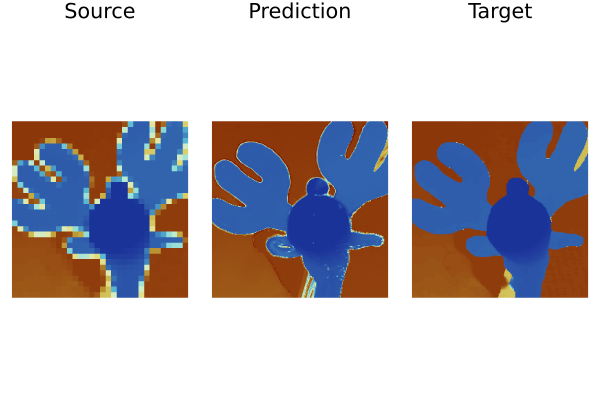

MSE: 74.556 | MAE: 2.204 | PBP: 0.183


In [6]:
θ = Dict(
            "scaling"=> 8,
            "channels"=> 5,
                    
            "batch"=> 32,
            "epoch"=> 1024,

            "α"=> relu,
            
            "ℓ"=> L1_ℓ,
            "reg"=> L2_reg,
            "λ"=> [1e-4, 1e-3, 1e-4],

            "optim"=> adam!,
            "lr"=> 1e-3,

            "Δ_PBP"=> 1,

            "atype" => CuArray # "Array"=CPU | "CuArray"=GPU
        )
        
depth_dataset = NPZ.npzread("data\\depth_sample_images.npz")
guides = permutedims(depth_dataset["guide_imgs"], [3,4,2,1])
targets = reshape(permutedims(depth_dataset["target_imgs"], [2,3,1]), (256, 256, 1, 3))
sources = pool(targets, window=θ["scaling"], mode=1)

Knet.atype() = θ["atype"]
prediction = predict(guides[:,:,:,1], sources[:,:,:,1])
show_results(sources[:,:,:,1], prediction, targets[:,:,:,1])